# Homework 1
## Mert Yuksekgonul 2016402147
## Note: This is the longer version, where I have used hyperparameter tuning using grid search in order to get an estimate of which hyperparameters to go for. The shorter and commented version of the report is in the file ```HW1-Summary.ipynb```

In [0]:
from keras import models
from keras import layers, regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import ParameterGrid
from keras import regularizers
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences

## General Purpose Functions <br>
### Train Function:
This function takes various parameters to handle the training phase for the experiments. It has several options for pre-processing, for different use cases.

In [0]:
def train(data, labels, folds, model_fn=None, model_params=dict(),
          preprocess="CountVector", convert_categorical=False, callbacks=None, batch_size=32, max_epochs=10, verbose=1):
  """ This function will be used to train a model with K-Fold cross validation, with given folds and data."""
  hist_list = []
  scores = []
  if convert_categorical:
    n_classes = max(labels)+1
    labels = keras.utils.to_categorical(labels, max(labels)+1)
    
  if preprocess=="Tokenizer":
    tokenizer = Tokenizer(num_words=10000)
    data = tokenizer.sequences_to_matrix(data, mode='binary')  
    
  elif preprocess=="Tokenizer_Sentence":
    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(data)
    data = tokenizer.texts_to_sequences(data)
    data = pad_sequences(data, maxlen=100)

  for i, (train_idx, val_idx) in enumerate(folds):
    x_train = np.array(data)[train_idx]
    y_train = labels[train_idx]
    x_val = np.array(data)[val_idx]
    y_val = labels[val_idx]
    
    if preprocess=="Normalize":
      mean = x_train.mean(axis=0)
      x_train -= mean
      std = x_train.std(axis=0)
      x_train /= std
      x_val -= mean
      x_val /= std
    
    elif preprocess=="CountVector":
      tokenizer = CountVectorizer()
      tokenizer.fit(x_train)
      x_val = tokenizer.transform(x_val).toarray()
      x_train = tokenizer.transform(x_train).toarray()
    
    model = model_fn(**model_params)
    history = model.fit(x_train, y_train, batch_size=batch_size, epochs=max_epochs, verbose=verbose, validation_data=(x_val, y_val))
    score = model.evaluate(x_val, y_val, verbose=0)
    hist_list.append(history)
    scores.append(score)
  print("Mean score: ",np.mean(np.array(scores)[:,1]))
  #print("1 5-fold training step completed.")
  return hist_list, scores
    

# Question 1

## 1.1 Loading Data

In [0]:
#!wget -cq "https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip" -O data.zip
#!unzip data.zip
data = read_csv("./sentiment labelled sentences/imdb_labelled.txt", sep="\t", names=["sentence", "label"])
sentences = data.sentence.values
labels = data.label.values
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1997).split(sentences, labels))

max_words = 10000
max_input = 100
embedding_dim = 100

## 1.2 Model Function for Sentiment Analysis Experiments

In [0]:
def sentiment_model(n_layers=2, n_hidden=[32, 64], dropout=0.2, use_dropout=False, activation="relu", optimizer="adam", reg=None):
  if reg is None:
    regularizer = None
  elif reg=="l2":
    regularizer = regularizers.l2(0.01)
  elif reg=="l1":
    regularizer = regularizers.l1(0.01)
  model = Sequential()
  #model.add(Embedding(max_words, embedding_dim, input_length=max_input))
  #model.add(Flatten())
  model.add(Dense(n_hidden[0], kernel_regularizer=regularizer))
  model.add(Activation(activation))
  if use_dropout:
    model.add(Dropout(rate = dropout))
  for i in range(n_layers-1):
    model.add(Dense(n_hidden[i+1]))
    model.add(Activation(activation))
    if use_dropout:
      model.add(Dropout(rate = dropout))
  model.add(Dense(1))
  model.add(Activation("sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

In [0]:
def sentiment_embedding_model(kernel_size, n_filters, embedding_dim, max_input=100,
                    activation="relu", optimizer="adam", reg=None):
    model = Sequential()
    model.add(layers.Embedding(10000, embedding_dim, input_length=max_input))
    model.add(layers.Conv1D(n_filters, kernel_size, activation=activation))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

## 1.3 Training Phase and Hyperparameter Tuning using Grid Search

#### I have tried 2 different types of models, one is a model with embedding and convolutional layers and the other one is a basic feedforward network.

In [0]:
param_grid = {"n_layers":[1,2] ,"n_hidden":[[16,32], [32,32]],
             "activation":["relu", "tanh"],"optimizer":["adam","rmsprop"]}
param_grid_2 = {"activation":["relu", "tanh"],"optimizer":["adam","rmsprop"], "kernel_size": [5,7], "embedding_dim":[50],
             "n_filters":[64,128]}

grid = ParameterGrid(param_grid)
grid2 = ParameterGrid(param_grid_2)
best = -float("inf")
best_p = None
best_hist = None
all_hist = []

for params in grid:
  print("Params: ",params)
  hist, scores = train(sentences, labels, folds, sentiment_model, params,
                       "CountVector", False, None, verbose=0, max_epochs=30, batch_size=32)
  mean_ac = np.mean(np.array(scores)[:,1])
  if mean_ac>best:
    best = mean_ac
    best_p = params
    best_hist = hist
    print("Current Best: ")
    print("Params: ", params)
    print("Mean Accuracy: ",mean_ac)
  del hist

print("Here Embedding Model begins")

for params in grid2:
  print("Params: ",params)
  hist, scores = train(sentences, labels, folds, sentiment_embedding_model, params,
                       "Tokenizer_Sentence", False, None, verbose=0, max_epochs=30, batch_size=32)
  mean_ac = np.mean(np.array(scores)[:,1])
  if mean_ac>best:
    best = mean_ac
    best_p = params
    best_hist = hist
    print("Current Best: ")
    print("Params: ", params)
    print("Mean Accuracy: ",mean_ac)
  del hist
  

print("Best params: ", best_p)

Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 1, 'optimizer': 'adam'}
Mean score:  0.7860549663690957
Current Best: 
Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 1, 'optimizer': 'adam'}
Mean Accuracy:  0.7860549663690957
Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 1, 'optimizer': 'rmsprop'}
Mean score:  0.7754057223747994
Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'adam'}
Mean score:  0.7740367122786747
Params:  {'activation': 'relu', 'n_hidden': [16, 32], 'n_layers': 2, 'optimizer': 'rmsprop'}
Mean score:  0.7513606236804469
Params:  {'activation': 'relu', 'n_hidden': [32, 32], 'n_layers': 1, 'optimizer': 'adam'}
Mean score:  0.772650044272041
Params:  {'activation': 'relu', 'n_hidden': [32, 32], 'n_layers': 1, 'optimizer': 'rmsprop'}
Mean score:  0.7633341336921228
Params:  {'activation': 'relu', 'n_hidden': [32, 32], 'n_layers': 2, 'optimizer': 'adam'}
Mean score:  0.776668059888588

## 1.4 Results

### 1.4.1 Loss Plots

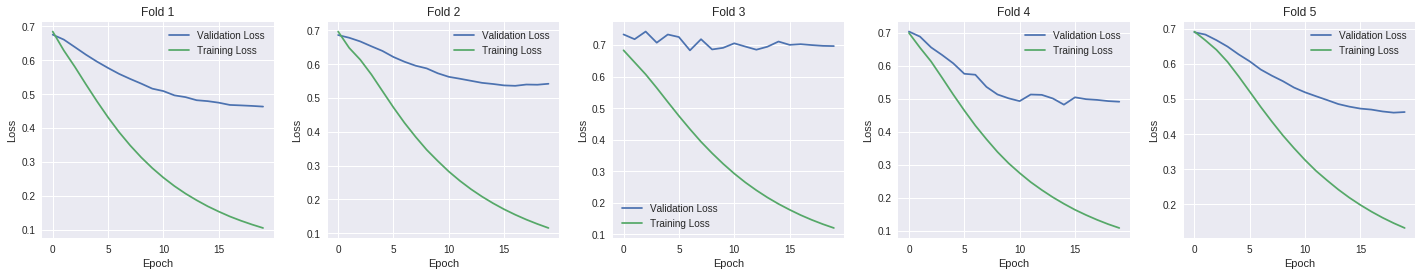

In [0]:
hist = best_hist
fig, ax = plt.subplots(nrows=1, ncols=5)
#ax = [item for sublist in ax for item in sublist]
for i, vals in enumerate(hist):
  ax[i].plot(vals.history["val_loss"], label="Validation Loss")
  ax[i].plot(vals.history["loss"], label="Training Loss")
  ax[i].set_ylabel("Loss")
  ax[i].set_xlabel("Epoch")
  ax[i].set_title(" ".join(["Fold", str(i+1)]))
  ax[i].legend()
fig.set_figheight(4)
fig.set_figwidth(20)
fig.tight_layout()
plt.show()

### 1.4.2 Accuracy Plots

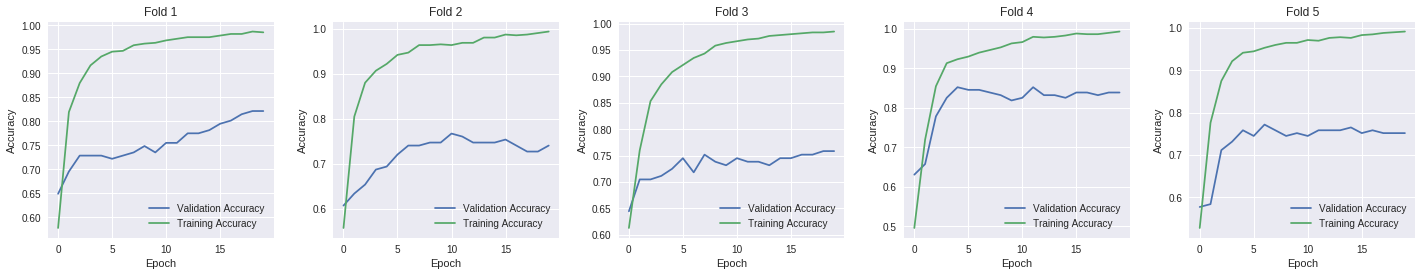

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=5)
#ax = [item for sublist in ax for item in sublist]
for i, vals in enumerate(hist):
  ax[i].plot(vals.history["val_acc"], label="Validation Accuracy")
  ax[i].plot(vals.history["acc"], label="Training Accuracy")
  ax[i].set_ylabel("Accuracy")
  ax[i].set_xlabel("Epoch")
  ax[i].set_title(" ".join(["Fold", str(i+1)]))
  ax[i].legend()
fig.set_figheight(4)
fig.set_figwidth(20)
fig.tight_layout()
plt.show()

# Question 2

## 2.1. Loading Reuters data, preparing folds

In [0]:
from keras.datasets import reuters
(data, labels), obj2 = reuters.load_data(num_words=10000, test_split=0)
n_classes = max(labels)+1
folds = list(StratifiedKFold(n_splits=5, shuffle=True, random_state=1997).split(data, labels))

2113536/2110848 [==============================] - 0s 0us/step


## 2.2. Model Function for Reuters experiments

In [0]:
def reuters_model(n_layers=2, n_hidden_units=[64,64], dropout=0.2, opt="adam", use_dropout=False, reg=None):
  if reg is None:
    regularizer = None
  elif reg=="l2":
    regularizer = regularizers.l2(0.01)
  elif reg=="l1":
    regularizer = regularizers.l1(0.01)
  model = Sequential()
  model.add(Dense(n_hidden_units[0], input_shape = (10000, ), kernel_regularizer=regularizer))
  model.add(Activation("relu"))
  if use_dropout:
    model.add(Dropout(rate = dropout))
  for i in range(n_layers-1):
    model.add(Dense(n_hidden_units[i+1], kernel_regularizer=regularizer))
    model.add(Activation("relu"))
    if use_dropout:
      model.add(Dropout(rate = dropout))
  model.add(Dense(n_classes))
  model.add(Activation("softmax"))
  model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model

## 2.3. Training Phase and Hyperparameter Tuning using Grid Search

In [0]:
param_grid = {"reg":[None, "l2"], "n_layers":[2,3], "n_hidden_units":[[32,32,64], [32, 64, 64],[64,64, 64], [64,128, 128]]}
grid = ParameterGrid(param_grid)
best = float("inf")
best_p = None
best_hist = None
all_hist = []

for params in grid:
  hist, scores = train(data, labels, folds, reuters_model, params,
                       "Tokenizer", True, None, verbose=0, max_epochs=20, batch_size=128)
  mean_ce = np.mean(np.array(scores)[:,0])
  if mean_ce<best:
    best = mean_ce
    best_p = params
    best_hist = hist
    print("Current Best: ")
    print("Params: ", params)
    print("Mean Loss: ",mean_ce)
  del hist
print("Best params: ", best_p)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
1 5-fold training step completed.
Current Best: 
Params:  {'n_hidden_units': [32, 32, 64], 'n_layers': 2, 'reg': None}
Mean Loss:  1.1241852780406096
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
Current Best: 
Params:  {'n_hidden_units': [32, 64, 64], 'n_layers': 2, 'reg': None}
Mean Loss:  1.1092040821511808
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
Current Best: 
Params:  {'n_hidden_units': [64, 64, 64], 'n_layers': 2, 'reg': None}
Mean Loss:  1.047747258315192
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
Current Best: 
Params:  {'n_hidden_units': [64, 128, 128], 'n_layers': 2, 'reg': None}
Mean

In [0]:
param_grid = {"reg":[None, "l2"], "n_layers":[2], "use_dropout" : [True, False],"n_hidden_units":[[128,128], [128,256], [256,256]]}
grid = ParameterGrid(param_grid)
best = float("inf")
best_p = None
best_hist = None

for params in grid:
  hist, scores = train(data, labels, folds, reuters_model, params,
                       "Tokenizer", True, None, verbose=0, max_epochs=20, batch_size=128)
  mean_ce = np.mean(np.array(scores)[:,0])
  if mean_ce<best:
    best = mean_ce
    best_p = params
    best_hist = hist
    print("Current Best: ")
    print("Params: ", params)
    print("Mean Loss: ",mean_ce)
  del hist
print("Best params: ", best_p)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
1 5-fold training step completed.
Current Best: 
Params:  {'n_hidden_units': [128, 128], 'n_layers': 2, 'reg': None, 'use_dropout': True}
Mean Loss:  1.0627497931066732
1 5-fold training step completed.
Current Best: 
Params:  {'n_hidden_units': [128, 128], 'n_layers': 2, 'reg': None, 'use_dropout': False}
Mean Loss:  1.029308707912333
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
Best params:  {'n_hidden_units': [128, 128], 'n_layers': 2, 'reg': None, 'use_dropout': False}


## 2.4. Results

### 2.4.1 Loss Plots 

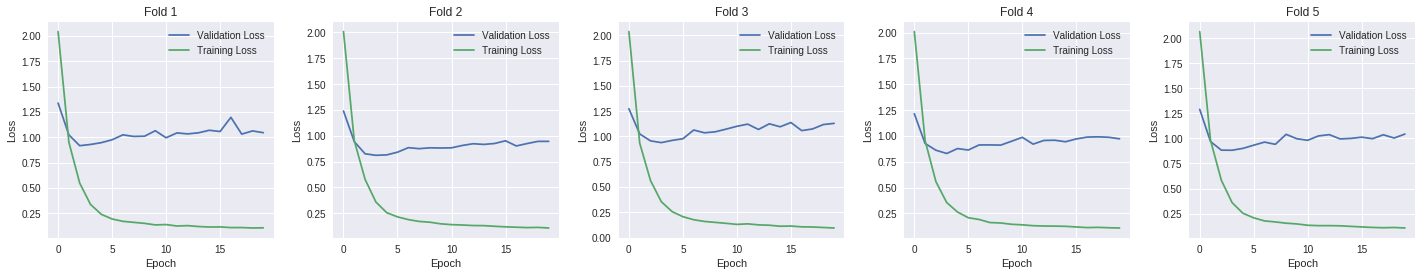

In [0]:
hist = best_hist
fig, ax = plt.subplots(nrows=1, ncols=5)
#ax = [item for sublist in ax for item in sublist]
for i, vals in enumerate(hist):
  ax[i].plot(vals.history["val_loss"], label="Validation Loss")
  ax[i].plot(vals.history["loss"], label="Training Loss")
  ax[i].set_ylabel("Loss")
  ax[i].set_xlabel("Epoch")
  ax[i].set_title(" ".join(["Fold", str(i+1)]))
  ax[i].legend()
fig.set_figheight(4)
fig.set_figwidth(20)
fig.tight_layout()
plt.show()

### 2.4.2 Accuracy Plots

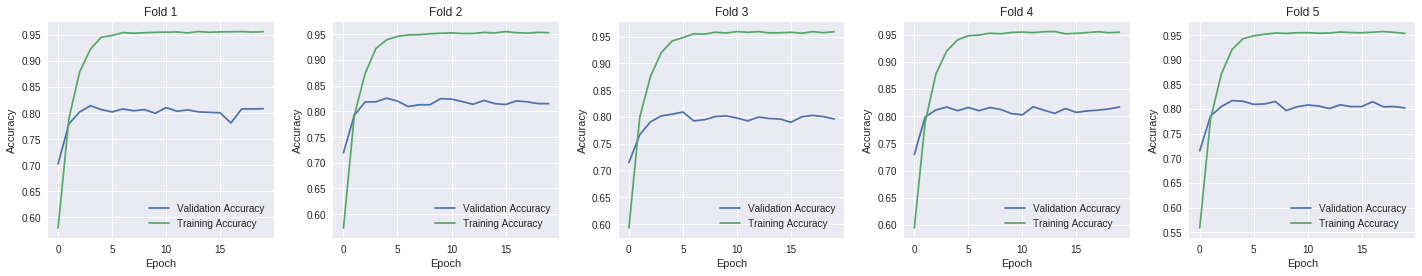

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=5)
#ax = [item for sublist in ax for item in sublist]
for i, vals in enumerate(hist):
  ax[i].plot(vals.history["val_acc"], label="Validation Accuracy")
  ax[i].plot(vals.history["acc"], label="Training Accuracy")
  ax[i].set_ylabel("Accuracy")
  ax[i].set_xlabel("Epoch")
  ax[i].set_title(" ".join(["Fold", str(i+1)]))
  ax[i].legend()
fig.set_figheight(4)
fig.set_figwidth(20)
fig.tight_layout()
plt.show()

## The function to conduct the training phase

# Question 3

## 3.1 Loading Boston-Housing Data

In [0]:
from keras.datasets import boston_housing
(data, target), _ = boston_housing.load_data(test_split=0)
folds = list(KFold(n_splits=5, shuffle=True, random_state=1997).split(data, target))

57344/57026 [==============================] - 0s 0us/step


## 3.2 Model Function for Regression

In [0]:
def boston_model(n_layers=2, n_hidden_units=[64,128], reg=None, use_dropout=True, opt="adam", Loss="mse"):
  if reg is None:
    regularizer = None
  if reg == "l2":
    regularizer = regularizers.l2(0.01)
  elif reg == "l1":
    regularizer = regularizers.l1(0.01)
  model = Sequential()
  model.add(Dense(n_hidden_units[0], input_shape = (13, ), kernel_regularizer=regularizer))
  model.add(Activation("relu"))
  if use_dropout:
    model.add(Dropout(rate=0.2))
  for i in range(n_layers-1):
    model.add(Dense(n_hidden_units[i+1], kernel_regularizer=regularizer))
    model.add(Activation("relu"))
    if use_dropout:
      model.add(Dropout(rate=0.2))
  model.add(Dense(1))
  model.compile(loss=Loss, optimizer=opt, metrics=['mae'])
  return model

## 3.3 Training Phase and Hyperparameter Tuning using Grid Search

In [0]:
param_grid = {"Loss": ["mae", "mse"], "reg":[None, "l2", "l1"],
              "use_dropout":[True, False], "n_layers":[2,3], "n_hidden_units":[[32,32,64], [32, 64, 64],[64,64, 64], [64,128, 128]]}
grid = ParameterGrid(param_grid)

best = float("inf")
best_p = None
best_hist = None

for params in grid:
  hist, scores = train(data, target, folds, boston_model, params,
                       "Normalize", False, None, verbose=0, max_epochs=500, batch_size=128)
  mean_mae = np.mean(np.array(scores)[:,1])
  if mean_mae<best:
    best = mean_mae
    best_p = params
    best_hist = hist
    print("Current Best: ")
    print("Params: ", params)
    print("Mean MAE: ",mean_mae)
print("Best params: ", best_p)

1 5-fold training step completed.
Current Best: 
Params:  {'Loss': 'mae', 'n_hidden_units': [32, 32, 64], 'n_layers': 2, 'reg': None, 'use_dropout': True}
Mean MAE:  2.4359390587789114
1 5-fold training step completed.
Current Best: 
Params:  {'Loss': 'mae', 'n_hidden_units': [32, 32, 64], 'n_layers': 2, 'reg': None, 'use_dropout': False}
Mean MAE:  2.317920373514124
1 5-fold training step completed.
1 5-fold training step completed.
Current Best: 
Params:  {'Loss': 'mae', 'n_hidden_units': [32, 32, 64], 'n_layers': 2, 'reg': 'l2', 'use_dropout': False}
Mean MAE:  2.27067524636979
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
1 5-fold training step completed.
Curr

### 3.4.1 Training Results and Comments: 

## 3.4 Results

### 3.4.1 Loss Plots

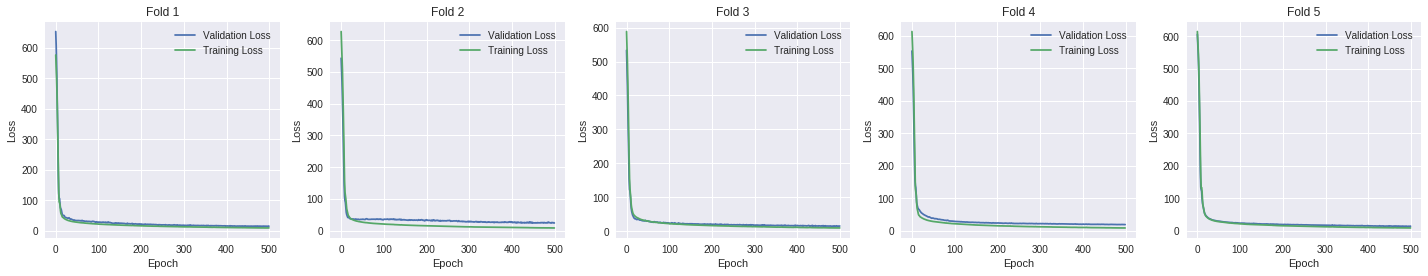

In [0]:
hist = best_hist
fig, ax = plt.subplots(nrows=1, ncols=5)
#ax = [item for sublist in ax for item in sublist]
for i, vals in enumerate(hist):
  ax[i].plot(vals.history["val_loss"], label="Validation Loss")
  ax[i].plot(vals.history["loss"], label="Training Loss")
  ax[i].set_ylabel("Loss")
  ax[i].set_xlabel("Epoch")
  ax[i].set_title(" ".join(["Fold", str(i+1)]))
  ax[i].legend()
fig.set_figheight(4)
fig.set_figwidth(20)
fig.tight_layout()
plt.show()

### 3.4.2 MAE Plots

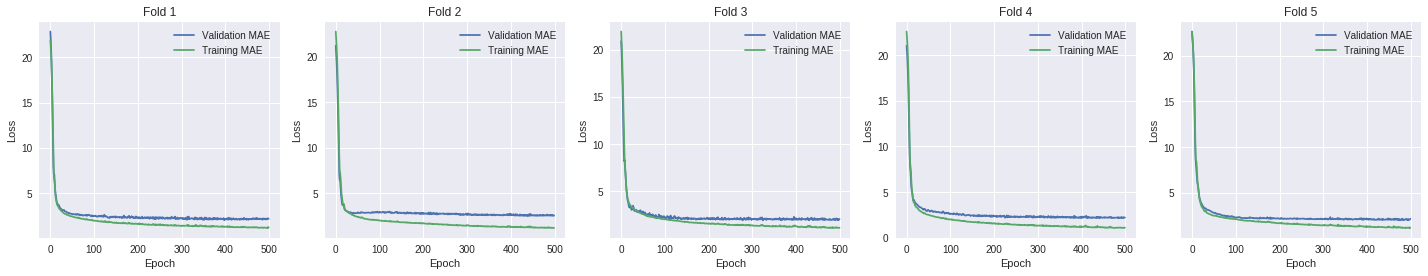

In [0]:
fig, ax = plt.subplots(nrows=1, ncols=5)
#ax = [item for sublist in ax for item in sublist]
for i, vals in enumerate(hist):
  ax[i].plot(vals.history["val_mean_absolute_error"], label="Validation MAE")
  ax[i].plot(vals.history["mean_absolute_error"], label="Training MAE")
  ax[i].set_ylabel("Loss")
  ax[i].set_xlabel("Epoch")
  ax[i].set_title(" ".join(["Fold", str(i+1)]))
  ax[i].legend()
fig.set_figheight(4)
fig.set_figwidth(20)
fig.tight_layout()
plt.show()